In [ ]:
import numpy as np, torch, time, os
from Ctubes.geometry_utils import compute_plane_normals, regular_polygon
from Ctubes.plot_utils import plot_generatrix
from Ctubes.tubes import Directrix, Generatrix, CTube
from Ctubes.target_cross_sections import fix_end_cross_sections
from Ctubes.opt import CTubeOptimizationProblem
from Ctubes.misc_utils import load_curve_from_obj
from Ctubes.path_utils import get_name, setup_paths

paths = setup_paths(get_name())

PI = np.pi
TORCH_DTYPE = torch.float64
torch.set_default_dtype(TORCH_DTYPE)
torch.set_printoptions(precision=4)

%load_ext autoreload
%autoreload 2

%matplotlib widget

# Figure 10: Non-Planar Generatrices

## #1: Planar Generatrix (Reference)

In [3]:
# Define a path to output specific to the current test case
paths = setup_paths(get_name(), test_name="fig10_nonplanar_planar")

In [4]:
# Directrix: read curve from file
cps_ref = load_curve_from_obj(os.path.join(paths["data"], "fig10_nonplanar/directrix_Q.obj"))
K = cps_ref.shape[0]
M = K

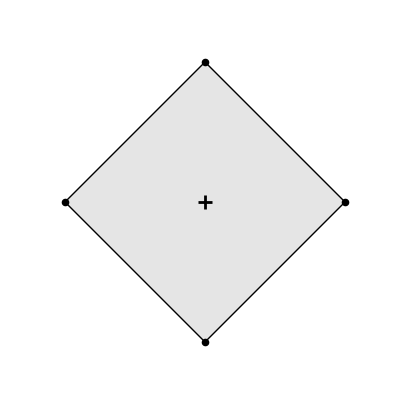

In [5]:
# Generatrix: regular N-gon
N = 4
tube_radius = 2.0
generatrix_2d = regular_polygon(N, tube_radius)

fig, ax = plot_generatrix(generatrix_2d)

In [6]:
# C-tube
directrix = Directrix(cps_ref, M)

X0 = directrix.X[0]
T0 = directrix.get_tangents()[0]
generatrix = Generatrix(generatrix_2d, X0, T0)

tube = CTube(directrix, generatrix)

In [7]:
tube.has_planar_profile()

True

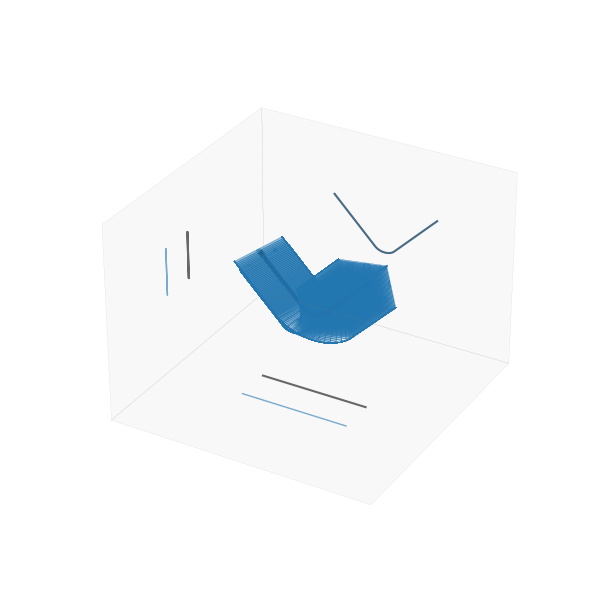

In [8]:
fig, ax = tube.plot_3d()

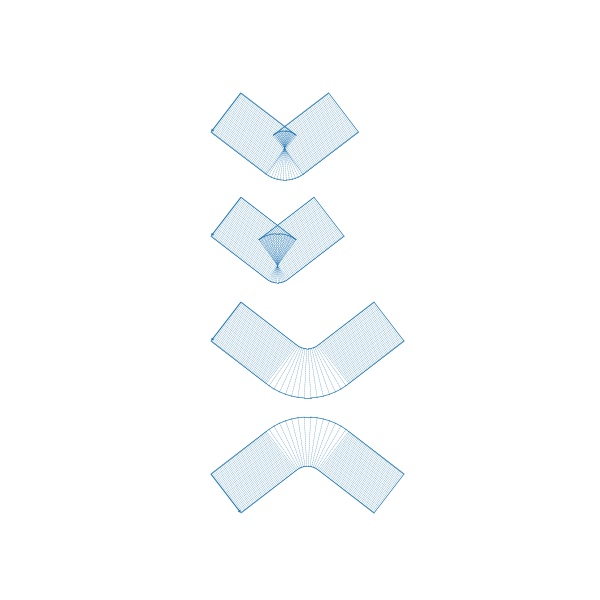

In [9]:
fig, ax = tube.plot_unrolled_strips()

### Optimization

In [16]:
directrix.aabb_diagonal_length() ** 2

tensor(48.4730)

In [ ]:
# Set up optimization problem

opt_weights = {
    'match_target_cross_sections': 1e2 / generatrix.aabb_diagonal_length() ** 2,
}

objective_args = {
    'target_cross_sections': fix_end_cross_sections(tube),
}

opt_prob = CTubeOptimizationProblem(
    tube, 
    opt_weights, 
    objective_args,
)

opt_prob.activate_cps(False)
opt_prob.activate_theta(False)
opt_prob.activate_apex_loc_func(False)
opt_prob.activate_plane_normals(True)

In [11]:
opt_prob.opt_weights['smooth_plane_normal_diffs'] = 0.0  # deactivate plane normal smoothing to avoid confounding the comparison between planar and nonplanar

In [12]:
opt_prob.compute_objective(print_to_console=True)

match_target_cross_sections             : 0.0000000000
smooth_plane_normal_diffs               : 0.0000000000
preserve_tube_ridge_edge_directions     : 0.0917830090
unitary_plane_normals                   : 0.0000000000


tensor(0.0918)

In [13]:
# Save initial state
paths_init = setup_paths(get_name(), test_name="fig10_nonplanar_init")

opt_prob.save_meshes(paths=paths_init)
opt_prob.save_optimization_results(paths=paths_init)

In [14]:
from scipy.optimize import minimize
from Ctubes.opt import obj_and_grad

torch.autograd.set_detect_anomaly(False)

# Set up optimization configuration
opt_prob.configure_optimization_output(paths)

# Get initial parameters
params0 = opt_prob.get_params_numpy()

# Define objective and gradient function for SciPy
obj_and_grad_scipy = lambda params: obj_and_grad(params, opt_prob)

# Fix variables via double-sided bounds
fixed_indices = []  # no fixed DOF by default

bounds = [(None, None)] * len(params0)
for idx in fixed_indices:
    bounds[idx] = (params0[idx], params0[idx])
print(f"Fixing {len(fixed_indices)} parameters.")

# Add initial state to history
opt_prob.add_objective_to_history()

Fixing 0 parameters.


In [58]:
# Run optimization
start_time = time.time()
result = minimize(
    obj_and_grad_scipy, 
    params0, 
    jac=True, 
    method='L-BFGS-B',
    options={'ftol': 1.0e-10, 'gtol': 1.0e-5, 'disp': True, 'maxiter': 2000},
    bounds=bounds,
    callback=opt_prob.optimization_callback,
)
result.execution_time = time.time() - start_time

# Finalize optimization (save results, render videos, cleanup)
opt_prob.finalize_optimization(result)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          300     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.44899D-02    |proj g|=  6.09707D-02

At iterate    1    f=  4.42346D-02    |proj g|=  6.80305D-02

At iterate    2    f=  4.37282D-02    |proj g|=  4.81002D-02

At iterate    3    f=  4.35369D-02    |proj g|=  4.60171D-02

At iterate    4    f=  4.33102D-02    |proj g|=  2.94337D-02

At iterate    5    f=  4.28096D-02    |proj g|=  5.06986D-02

At iterate    6    f=  4.22698D-02    |proj g|=  1.19189D-01

At iterate    7    f=  4.14745D-02    |proj g|=  7.41667D-02


 This problem is unconstrained.



At iterate    8    f=  4.07596D-02    |proj g|=  4.95251D-02

At iterate    9    f=  3.98146D-02    |proj g|=  1.29256D-01

At iterate   10    f=  3.90050D-02    |proj g|=  7.87661D-02

At iterate   11    f=  3.77721D-02    |proj g|=  5.33524D-02

At iterate   12    f=  3.72614D-02    |proj g|=  4.41469D-02

At iterate   13    f=  3.67399D-02    |proj g|=  7.71148D-02

At iterate   14    f=  3.62073D-02    |proj g|=  6.52876D-02

At iterate   15    f=  3.56913D-02    |proj g|=  6.13473D-02

At iterate   16    f=  3.50699D-02    |proj g|=  4.08373D-02

At iterate   17    f=  3.39885D-02    |proj g|=  8.02602D-02

At iterate   18    f=  3.24325D-02    |proj g|=  9.65460D-02

At iterate   19    f=  3.16803D-02    |proj g|=  8.06926D-02

At iterate   20    f=  3.11162D-02    |proj g|=  8.66631D-02

At iterate   21    f=  3.05718D-02    |proj g|=  8.60533D-02

At iterate   22    f=  3.02238D-02    |proj g|=  1.31149D-01

At iterate   23    f=  2.91482D-02    |proj g|=  1.52244D-01

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate  572    f=  1.52359D-05    |proj g|=  2.70629D-03

At iterate  573    f=  1.47719D-05    |proj g|=  1.54433D-03

At iterate  574    f=  1.44094D-05    |proj g|=  2.15279D-03

At iterate  575    f=  1.38873D-05    |proj g|=  1.19539D-03

At iterate  576    f=  1.36959D-05    |proj g|=  8.63044D-04

At iterate  577    f=  1.34416D-05    |proj g|=  1.62724D-03

At iterate  578    f=  1.32175D-05    |proj g|=  1.30405D-03

At iterate  579    f=  1.30134D-05    |proj g|=  8.72342D-04

At iterate  580    f=  1.28159D-05    |proj g|=  8.69912D-04

At iterate  581    f=  1.26613D-05    |proj g|=  1.22559D-03

At iterate  582    f=  1.25429D-05    |proj g|=  1.76147D-03

At iterate  583    f=  1.24113D-05    |proj g|=  9.31935D-04

At iterate  584    f=  1.22420D-05    |proj g|=  1.00530D-03

At iterate  585    f=  1.20603D-05    |proj g|=  1.35191D-03

At iterate  586    f=  1.18753D-05    |proj g|=  9.88128D-04

At iterate  587    f=  1.16923D-05    |proj g|=  1.24501D-03

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


In [59]:
opt_prob.compute_objective(print_to_console=True)

match_target_cross_sections             : 0.0000000003
smooth_plane_normal_diffs               : 0.0000000000
preserve_tube_ridge_edge_directions     : 0.0000000003
unitary_plane_normals                   : 0.0000008538


tensor(8.5435e-07)

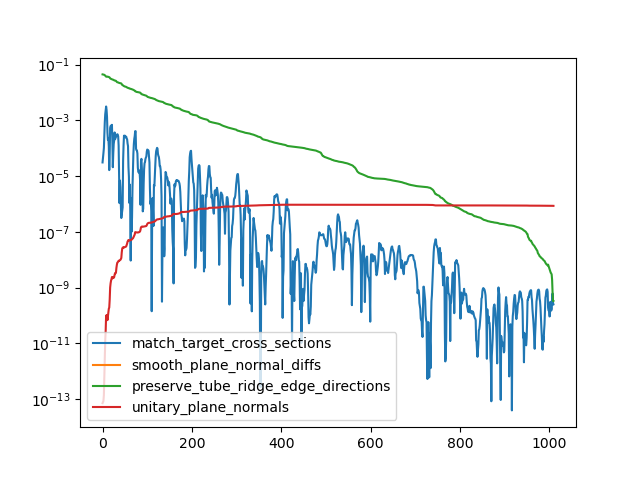

In [60]:
fig, ax = opt_prob.plot_objective_history()

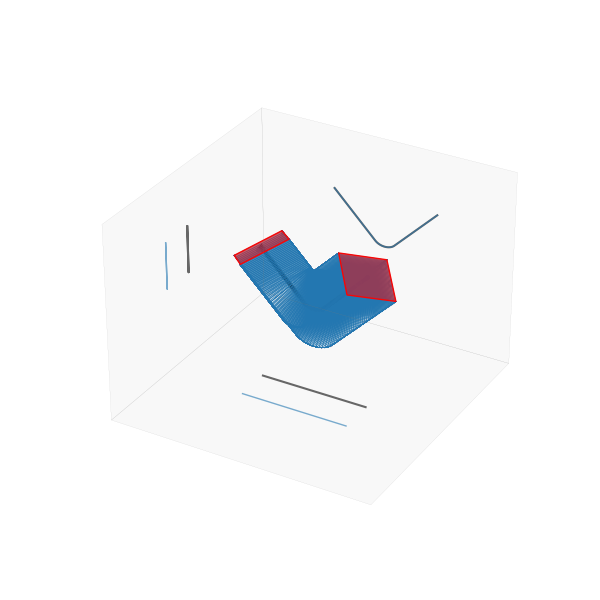

In [61]:
fig, ax = opt_prob.plot_3d()

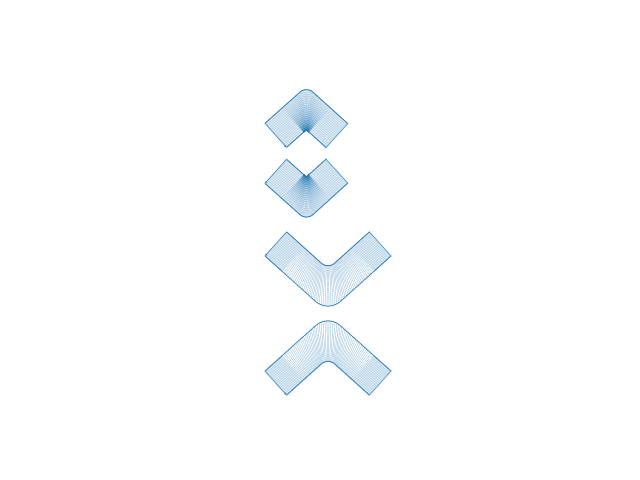

In [62]:
fig, ax = opt_prob.plot_unrolled_strips()

In [ ]:
# Find non-planar cross-sections
from Ctubes.geometry_utils import point_cloud_is_planar

ctube_vertices = opt_prob.tube_network.compute_vertices()[0]
non_planar_cross_sections = []
for i in range(M):
    pts = ctube_vertices[i]
    if not point_cloud_is_planar(pts):
        non_planar_cross_sections.append(i)

# Find points at which the plane normals differ
plane_normals = opt_prob.tube_network.tubes[0].get_plane_normals()
distinct_plane_normals = []
if not opt_prob.tube_network.has_planar_profile():
    for i in range(M):
        all_same = True
        for j in range(1, N):
            if not torch.allclose(plane_normals[i][j], plane_normals[i][0]):
                all_same = False
                break
        if not all_same:
            distinct_plane_normals.append(i)

print(f"Non-planar cross-sections: \n{non_planar_cross_sections}")
print(f"Distinct plane normals: \n{distinct_plane_normals}")

Non-planar cross-sections: 
[]
Distinct plane normals: 
[]


## #2: Non-Planar Generatrix

In [23]:
# Define a path to output specific to the current test case
paths = setup_paths(get_name(), test_name="fig10_nonplanar_nonplanar")

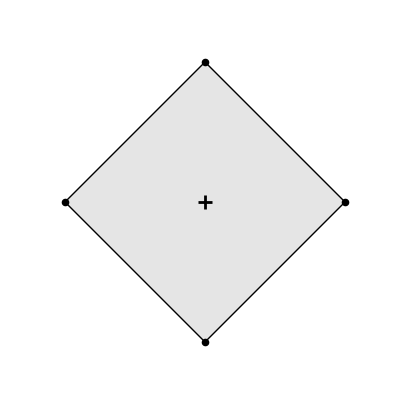

In [24]:
# Generatrix: regular N-gon
N = 4
tube_radius = 2.0
generatrix_2d = regular_polygon(N, tube_radius)

fig, ax = plot_generatrix(generatrix_2d)

In [25]:
# Directrix: read curve from file
cps_ref = load_curve_from_obj(os.path.join(paths["data"], "fig10_nonplanar/directrix_Q.obj"))
K = cps_ref.shape[0]
M = K

In [26]:
# C-tube
directrix = Directrix(cps_ref, M)

X0 = directrix.X[0]
T0 = directrix.get_tangents()[0]
generatrix = Generatrix(generatrix_2d, X0, T0)

plane_normals_ref = compute_plane_normals(directrix.X, kind='bisecting', closed_curve=directrix.closed_curve)
plane_normals_per_ridge = []
for i in range(N):
    pn = plane_normals_ref.clone()
    plane_normals_per_ridge.append(pn)
plane_normals_ref = torch.swapaxes(torch.stack(plane_normals_per_ridge), 0, 1)  # shape (M, N, 3), one plane per generatrix point

tube = CTube(directrix, generatrix, plane_normals_ref)

In [27]:
tube.has_planar_profile()

False

Plot

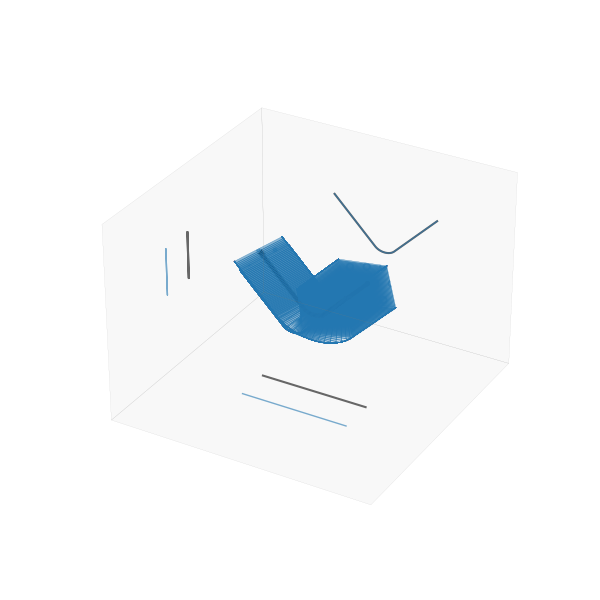

In [28]:
fig, ax = tube.plot_3d()

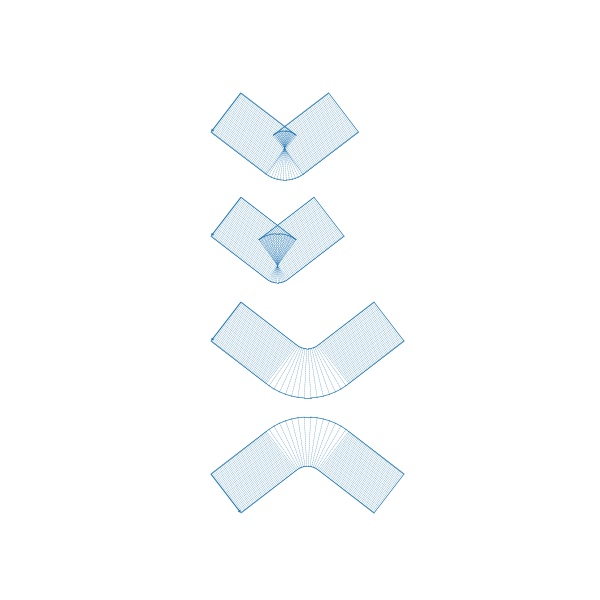

In [29]:
fig, ax = tube.plot_unrolled_strips()

### Optimization

In [ ]:
# Set up optimization problem

opt_weights = {
    'match_target_cross_sections': 1e2 / generatrix.aabb_diagonal_length() ** 2,
}

objective_args = {
    'target_cross_sections': fix_end_cross_sections(tube),
}

opt_prob = CTubeOptimizationProblem(
    tube, 
    opt_weights, 
    objective_args,
)

opt_prob.activate_cps(False)
opt_prob.activate_theta(False)
opt_prob.activate_apex_loc_func(False)
opt_prob.activate_plane_normals(True)

In [31]:
opt_prob.opt_weights['smooth_plane_normal_diffs'] = 0.0  # deactivate plane normal smoothing to avoid confounding the comparison between planar and nonplanar

In [32]:
opt_prob.compute_objective(print_to_console=True)

match_target_cross_sections             : 0.0000000000
smooth_plane_normal_diffs               : 0.0000000000
preserve_tube_ridge_edge_directions     : 0.0444899485
unitary_plane_normals                   : 0.0000000000


tensor(0.0445)

In [ ]:
from scipy.optimize import minimize
from Ctubes.opt import obj_and_grad

torch.autograd.set_detect_anomaly(False)

# Set up optimization configuration
opt_prob.configure_optimization_output(paths)

# Get initial parameters
params0 = opt_prob.get_params_numpy()

# Define objective and gradient function for SciPy
obj_and_grad_scipy = lambda params: obj_and_grad(params, opt_prob)

# Fix variables via double-sided bounds
fixed_indices = []  # no fixed DOF by default

bounds = [(None, None)] * len(params0)
for idx in fixed_indices:
    bounds[idx] = (params0[idx], params0[idx])
print(f"Fixing {len(fixed_indices)} parameters.")

# Add initial state to history
opt_prob.add_objective_to_history()

Fixing 0 parameters.


In [34]:
# Run optimization
start_time = time.time()
result = minimize(
    obj_and_grad_scipy, 
    params0, 
    jac=True, 
    method='L-BFGS-B',
    options={'ftol': 1.0e-10, 'gtol': 1.0e-5, 'disp': True, 'maxiter': 2000},
    bounds=bounds,
    callback=opt_prob.optimization_callback,
)
result.execution_time = time.time() - start_time

# Finalize optimization (save results, render videos, cleanup)
opt_prob.finalize_optimization(result)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1200     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.44899D-02    |proj g|=  6.09707D-02

At iterate    1    f=  4.42350D-02    |proj g|=  6.93927D-02

At iterate    2    f=  4.37021D-02    |proj g|=  4.95751D-02

At iterate    3    f=  4.34789D-02    |proj g|=  4.93491D-02

At iterate    4    f=  4.32071D-02    |proj g|=  3.36753D-02

At iterate    5    f=  4.25238D-02    |proj g|=  5.74179D-02

At iterate    6    f=  4.18088D-02    |proj g|=  1.32220D-01

At iterate    7    f=  4.07893D-02    |proj g|=  8.05130D-02

At iterate    8    f=  4.01096D-02    |proj g|=  4.35025D-02

At iterate    9    f=  3.96370D-02    |proj g|=  3.67245D-02


 This problem is unconstrained.



At iterate   10    f=  3.92483D-02    |proj g|=  8.20434D-02

At iterate   11    f=  3.89490D-02    |proj g|=  1.47431D-01

At iterate   12    f=  3.78917D-02    |proj g|=  5.41393D-02

At iterate   13    f=  3.74837D-02    |proj g|=  4.74172D-02

At iterate   14    f=  3.68607D-02    |proj g|=  4.04082D-02

At iterate   15    f=  3.61725D-02    |proj g|=  7.66957D-02

At iterate   16    f=  3.55676D-02    |proj g|=  1.55072D-01

At iterate   17    f=  3.49219D-02    |proj g|=  1.61285D-01

At iterate   18    f=  3.43300D-02    |proj g|=  1.14231D-01

At iterate   19    f=  3.32230D-02    |proj g|=  3.77801D-02

At iterate   20    f=  3.26936D-02    |proj g|=  1.11005D-01

At iterate   21    f=  3.17842D-02    |proj g|=  1.20964D-01

At iterate   22    f=  3.08386D-02    |proj g|=  8.28776D-02

At iterate   23    f=  3.04288D-02    |proj g|=  8.38739D-02

At iterate   24    f=  2.91089D-02    |proj g|=  1.19438D-01

At iterate   25    f=  2.86347D-02    |proj g|=  5.98019D-02

At iter

In [35]:
opt_prob.compute_objective(print_to_console=True)

match_target_cross_sections             : 0.0000000001
smooth_plane_normal_diffs               : 0.0000000000
preserve_tube_ridge_edge_directions     : 0.0000000010
unitary_plane_normals                   : 0.0000008522


tensor(8.5326e-07)

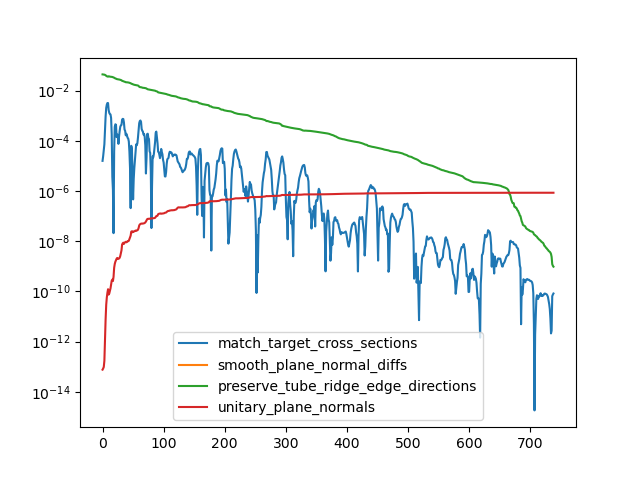

In [36]:
fig, ax = opt_prob.plot_objective_history()

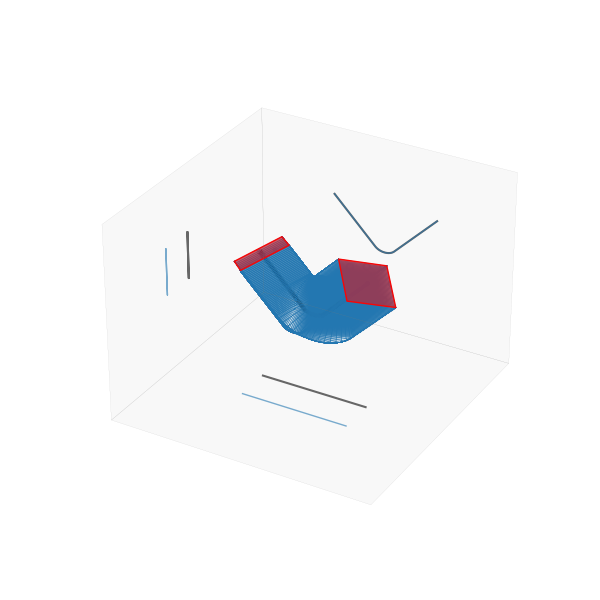

In [37]:
fig, ax = opt_prob.plot_3d()

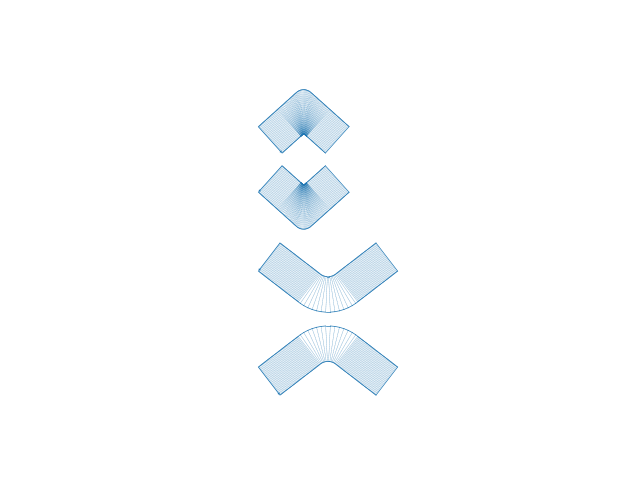

In [38]:
fig, ax = opt_prob.plot_unrolled_strips()

In [ ]:
# Find non-planar cross-sections
from Ctubes.geometry_utils import point_cloud_is_planar

ctube_vertices = opt_prob.tube_network.compute_vertices()[0]
non_planar_cross_sections = []
for i in range(M):
    pts = ctube_vertices[i]
    if not point_cloud_is_planar(pts):
        non_planar_cross_sections.append(i)

# Find points at which the plane normals differ
plane_normals = opt_prob.tube_network.tubes[0].get_plane_normals()
distinct_plane_normals = []
if not opt_prob.tube_network.has_planar_profile():
    for i in range(M):
        all_same = True
        for j in range(1, N):
            if not torch.allclose(plane_normals[i][j], plane_normals[i][0]):
                all_same = False
                break
        if not all_same:
            distinct_plane_normals.append(i)

print(f"Non-planar cross-sections: \n{non_planar_cross_sections}")
print(f"Distinct plane normals: \n{distinct_plane_normals}")

Non-planar cross-sections: 
[22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78]
Distinct plane normals: 
[22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78]
